# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

In [1]:
# # Be sure to install the latest version of RLlib and sundry requirements
# ! pip install -U ray[rllib]
# ! pip install requests pandas aiohttp psutil setproctitle grpcio tensorflow-gpu==1.14.0

In [2]:
# view dependencies
! pip list | grep tensorflow

tensorflow             1.14.0             
tensorflow-estimator   1.14.0             
tensorflow-gpu         1.14.0             


Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ten

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [4]:
# Start ray locally (there are lots of configurations)
# to remote access ray dashboard, use ssh -L 8888:localhost:8265 local_host@xxx.xxx.xxx.xx
# on local: http://localhost:8888
ray.init(num_cpus=8, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

2020-03-12 11:40:58,743	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-12 11:40:58,746	INFO resource_spec.py:212 -- Starting Ray with 7.71 GiB memory available for workers and up to 3.86 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-12 11:40:59,074	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.236.176.76',
 'redis_address': '10.236.176.76:59197',
 'object_store_address': '/tmp/ray/session_2020-03-12_11-40-58_741923_17387/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-12_11-40-58_741923_17387/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-12_11-40-58_741923_17387'}

## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [19]:
import json
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied

In [20]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 7
config['num_envs_per_worker'] = 5
config['sample_batch_size'] = 50
config['train_batch_size'] = 1000
config['num_gpus'] = 1
config['lambda'] = 0.95
config['kl_coeff']= 0.5
config["sgd_minibatch_size"] = 500
config["num_sgd_iter"]= 10
config["vf_share_layers"] = True
config['clip_rewards'] = True
config['clip_param']= 0.1
config['vf_clip_param']= 10.0
config['entropy_coeff'] = 0.01
config['model']['dim'] = 42
# config['model']['framestack'] = False
# config['model']['grayscale'] = True
# config['model']['zero_mean'] = False


print(json.dumps(config, indent =2))

{
  "num_workers": 7,
  "num_envs_per_worker": 5,
  "sample_batch_size": 50,
  "batch_mode": "truncate_episodes",
  "num_gpus": 1,
  "train_batch_size": 1000,
  "model": {
    "conv_filters": null,
    "conv_activation": "relu",
    "fcnet_activation": "tanh",
    "fcnet_hiddens": [
      256,
      256
    ],
    "free_log_std": false,
    "no_final_linear": false,
    "vf_share_layers": true,
    "use_lstm": false,
    "max_seq_len": 20,
    "lstm_cell_size": 256,
    "lstm_use_prev_action_reward": false,
    "state_shape": null,
    "framestack": false,
    "dim": 42,
    "grayscale": true,
    "zero_mean": false,
    "custom_model": null,
    "custom_action_dist": null,
    "custom_options": {},
    "custom_preprocessor": null
  },
  "optimizer": {},
  "gamma": 0.99,
  "horizon": null,
  "soft_horizon": false,
  "no_done_at_end": false,
  "env_config": {},
  "env": null,
  "normalize_actions": false,
  "clip_rewards": true,
  "clip_actions": true,
  "preprocessor_pref": "deepmind",

2020-03-12 11:40:23,801	WARNING worker.py:1058 -- The actor or task with ID ffffffffffffffffbbd475a30100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {node:10.236.176.76: 1.000000}, {object_store_memory: 2.636719 GiB}, {memory: 7.714844 GiB}, {GPU: 1.000000}. In total there are 0 pending tasks and 6 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


In [8]:
agent = PPOTrainer(config, 'PongNoFrameskip-v4')

2020-03-12 11:23:55,967	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-12 11:23:56,005	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-12 11:24:01,928	WARNING util.py:37 -- Install gputil for GPU system monitoring.


In [16]:
# for i in range(1200):
#     result = agent.train()
#     if i % 20 == 0:
#         print(pretty_print(result))
#     if i % 100 == 0:
#         checkpoint = agent.save()
#         print("checkpoint saved at", checkpoint)


/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


custom_metrics: {}
date: 2020-03-12_11-24-29
done: false
episode_len_mean: .nan
episode_reward_max: .nan
episode_reward_mean: .nan
episode_reward_min: .nan
episodes_this_iter: 0
episodes_total: 0
experiment_id: c7a3ca05ba814d48968c8c28ec41f5f2
hostname: qian-XPS-8920
info:
  grad_time_ms: 1632.484
  learner:
    default_policy:
      cur_kl_coeff: 0.5
      cur_lr: 4.999999873689376e-05
      entropy: 5.093921208754182e-05
      entropy_coeff: 0.009999999776482582
      kl: 3.831181311397813e-05
      policy_loss: 0.00579747324809432
      total_loss: 0.005895944777876139
      vf_explained_var: -0.06581088155508041
      vf_loss: 7.982232637004927e-05
  load_time_ms: 62.865
  num_steps_sampled: 1750
  num_steps_trained: 1500
  sample_time_ms: 699.048
  update_time_ms: 295.626
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 7
off_policy_estimator: {}
perf:
  cpu_util_percent: 17.945
  ram_util_percent: 45.525
pid: 13049
policy_reward_max: {}
policy_reward_mean: 

custom_metrics: {}
date: 2020-03-12_11-25-01
done: false
episode_len_mean: 3056.0
episode_reward_max: -21.0
episode_reward_mean: -21.0
episode_reward_min: -21.0
episodes_this_iter: 0
episodes_total: 28
experiment_id: c7a3ca05ba814d48968c8c28ec41f5f2
hostname: qian-XPS-8920
info:
  grad_time_ms: 1070.231
  learner:
    default_policy:
      cur_kl_coeff: 4.76837158203125e-07
      cur_lr: 4.999999873689376e-05
      entropy: 2.075704497173092e-09
      entropy_coeff: 0.009999999776482582
      kl: -2.6611863754300025e-11
      policy_loss: -0.002027352573350072
      total_loss: 0.059860628098249435
      vf_explained_var: 0.1308598518371582
      vf_loss: 0.06188798323273659
  load_time_ms: 4.305
  num_steps_sampled: 36750
  num_steps_trained: 31500
  sample_time_ms: 509.796
  update_time_ms: 4.747
iterations_since_restore: 21
node_ip: 10.236.176.76
num_healthy_workers: 7
off_policy_estimator: {}
perf:
  cpu_util_percent: 40.95
  ram_util_percent: 47.5
pid: 13049
policy_reward_max: {}


custom_metrics: {}
date: 2020-03-12_11-28-13
done: false
episode_len_mean: 3056.0
episode_reward_max: -21.0
episode_reward_mean: -21.0
episode_reward_min: -21.0
episodes_this_iter: 0
episodes_total: 308
experiment_id: c7a3ca05ba814d48968c8c28ec41f5f2
hostname: qian-XPS-8920
info:
  grad_time_ms: 1074.048
  learner:
    default_policy:
      cur_kl_coeff: 0.0
      cur_lr: 4.999999873689376e-05
      entropy: 1.834410134904374e-08
      entropy_coeff: 0.009999999776482582
      kl: -6.209746605811972e-11
      policy_loss: 0.023369407281279564
      total_loss: 0.07352349907159805
      vf_explained_var: 0.41066861152648926
      vf_loss: 0.05015409365296364
  load_time_ms: 4.284
  num_steps_sampled: 246750
  num_steps_trained: 211500
  sample_time_ms: 513.489
  update_time_ms: 4.752
iterations_since_restore: 141
node_ip: 10.236.176.76
num_healthy_workers: 7
off_policy_estimator: {}
perf:
  cpu_util_percent: 40.199999999999996
  ram_util_percent: 50.6
pid: 13049
policy_reward_max: {}
po

custom_metrics: {}
date: 2020-03-12_11-31-26
done: false
episode_len_mean: 3056.0
episode_reward_max: -21.0
episode_reward_mean: -21.0
episode_reward_min: -21.0
episodes_this_iter: 0
episodes_total: 588
experiment_id: c7a3ca05ba814d48968c8c28ec41f5f2
hostname: qian-XPS-8920
info:
  grad_time_ms: 1073.333
  learner:
    default_policy:
      cur_kl_coeff: 0.0
      cur_lr: 4.999999873689376e-05
      entropy: 0.00013646365550812334
      entropy_coeff: 0.009999999776482582
      kl: 1.4926847313745384e-07
      policy_loss: -0.009190425276756287
      total_loss: 0.007298851851373911
      vf_explained_var: 0.7915675044059753
      vf_loss: 0.016490645706653595
  load_time_ms: 4.289
  num_steps_sampled: 456750
  num_steps_trained: 391500
  sample_time_ms: 513.541
  update_time_ms: 5.062
iterations_since_restore: 261
node_ip: 10.236.176.76
num_healthy_workers: 7
off_policy_estimator: {}
perf:
  cpu_util_percent: 40.35
  ram_util_percent: 53.6
pid: 13049
policy_reward_max: {}
policy_rewar

custom_metrics: {}
date: 2020-03-12_11-34-38
done: false
episode_len_mean: 3056.0
episode_reward_max: -21.0
episode_reward_mean: -21.0
episode_reward_min: -21.0
episodes_this_iter: 0
episodes_total: 868
experiment_id: c7a3ca05ba814d48968c8c28ec41f5f2
hostname: qian-XPS-8920
info:
  grad_time_ms: 1072.132
  learner:
    default_policy:
      cur_kl_coeff: 0.0
      cur_lr: 4.999999873689376e-05
      entropy: 0.1734672635793686
      entropy_coeff: 0.009999999776482582
      kl: 0.0002402952959528193
      policy_loss: 0.008744221180677414
      total_loss: 0.04495275020599365
      vf_explained_var: 0.5375247597694397
      vf_loss: 0.03794320300221443
  load_time_ms: 4.303
  num_steps_sampled: 666750
  num_steps_trained: 571500
  sample_time_ms: 513.125
  update_time_ms: 4.746
iterations_since_restore: 381
node_ip: 10.236.176.76
num_healthy_workers: 7
off_policy_estimator: {}
perf:
  cpu_util_percent: 31.53333333333333
  ram_util_percent: 56.70000000000001
pid: 13049
policy_reward_max

custom_metrics: {}
date: 2020-03-12_11-37-50
done: false
episode_len_mean: 3056.0
episode_reward_max: -21.0
episode_reward_mean: -21.0
episode_reward_min: -21.0
episodes_this_iter: 34
episodes_total: 1147
experiment_id: c7a3ca05ba814d48968c8c28ec41f5f2
hostname: qian-XPS-8920
info:
  grad_time_ms: 1072.852
  learner:
    default_policy:
      cur_kl_coeff: 0.0
      cur_lr: 4.999999873689376e-05
      entropy: 0.4693933427333832
      entropy_coeff: 0.009999999776482582
      kl: 0.0048005180433392525
      policy_loss: -0.005140386521816254
      total_loss: 0.01616048254072666
      vf_explained_var: 0.9407920241355896
      vf_loss: 0.02599480003118515
  load_time_ms: 4.242
  num_steps_sampled: 876750
  num_steps_trained: 751500
  sample_time_ms: 509.268
  update_time_ms: 4.9
iterations_since_restore: 501
node_ip: 10.236.176.76
num_healthy_workers: 7
off_policy_estimator: {}
perf:
  cpu_util_percent: 34.36666666666667
  ram_util_percent: 59.70000000000001
pid: 13049
policy_reward_ma

KeyboardInterrupt: 

In [10]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [7]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-12 11:42:44,278	WARNING util.py:37 -- Install gputil for GPU system monitoring.


(210, 160, 3)


ValueError: ('Observation outside expected value range', Box(84, 84, 4), array([[[143, 150, 137],
        [134,  13, 146],
        [ 81, 227,  66],
        ...,
        [225, 162, 106],
        [196, 164,  15],
        [210, 220,  41]],

       [[104,  54, 222],
        [201, 191,  86],
        [107, 145, 193],
        ...,
        [191, 206, 115],
        [ 58, 151, 254],
        [ 68,  17,   2]],

       [[  1,  86,  51],
        [ 96,  87, 158],
        [218, 176,  23],
        ...,
        [  0, 255,  89],
        [175, 212, 169],
        [122,   7,  24]],

       ...,

       [[ 27, 145, 252],
        [147,  83, 116],
        [151,  37, 250],
        ...,
        [231,  34, 214],
        [121, 176, 106],
        [ 99, 235, 119]],

       [[165,  98,  87],
        [ 24,  16, 195],
        [  2, 184,  57],
        ...,
        [ 22,  79, 209],
        [189,  49, 118],
        [ 19, 155, 186]],

       [[232,  11, 198],
        [ 63, 160,  57],
        [131, 248,  36],
        ...,
        [  7, 165, 153],
        [ 91, 115, 208],
        [  6,   6, 183]]], dtype=uint8))

In [12]:
print(env.observation_space)
print(env.action_space)
# print(env.observation_space.sample())

Box(210, 160, 3)
Discrete(6)


In [13]:
from ray.rllib.models.preprocessors import get_preprocessor
prep = get_preprocessor(env.observation_space)(env.observation_space, {"zero_mean":False,"dim":42, "grayscale":True})
print(prep.transform(env.observation_space.sample()).min())

0.24183008


In [14]:
# # compute some observation, then ask the agent to compute an action
# import cv2
# import numpy as np
# def preprocess(frame):
# #     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
# #     frame = cv2.resize(
# #         frame, (42, 42), interpolation=cv2.INTER_AREA)
# #     return frame[:, :, None]
#     scaled = frame[25:-25, :, :]
#     if 42 < 84:
#         scaled = cv2.resize(scaled, (84, 84))
#     # OpenAI: Resize by half, then down to 42x42 (essentially mipmapping).
#     # If we resize directly we lose pixels that, when mapped to 42x42,
#     # aren't close enough to the pixel boundary.
#     scaled = cv2.resize(scaled, (42, 42))
#     if True:
#         scaled = scaled.mean(2)
#         scaled = scaled.astype(np.float32)
#         # Rescale needed for maintaining 1 channel
#         scaled = np.reshape(scaled, [42, 42, 1])
#     if True:
#         scaled = (scaled - 128) / 128
#     else:
#         scaled *= 1.0 / 255.0
    
# #     print(scaled.shape)
#     return scaled



In [15]:
import gym
from gym import wrappers
from collections import deque

env = agent.env_creator({})
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()

obs = env.observation_space.sample()
# frames = deque([], maxlen=4)
accum = 0
for _ in range(10000):
    obs = prep.transform(obs)
#     obs = preprocess(obs)
#     frames.append(obs)
    frames = obs
    
#     if len(frames) == 4:
#     action = agent.compute_action(np.concatenate(frames, axis=2))
    action = agent.compute_action(frames)
#     else:
#         action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    accum += reward
    if done: break
print(accum)
env.close()

-21.0


In [31]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

In [11]:
# ## Save the agent off (this may become sticky depending which agent you've used)
# checkpoint_path = agent.save()
# print(checkpoint_path)

/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158


In [8]:
checkpoint_path = '/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158'
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
agent = PPOTrainer(trained_config, 'PongNoFrameskip-v4')
agent.restore(checkpoint_path) 


/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-12 00:45:25,475	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-12 00:45:25,520	WARNING trainable.py:210 -- Getting current IP.
2020-03-12 00:45:25,521	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158
2020-03-12 00:45:25,521	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 1158, '_timesteps_total': 2026500, '_time_total': 1925.0910727977753, '_episodes_total': 1901}
2020-03-12 00:45:36,286	WARNING worker.py:1058 -- The actor or task with ID ffffffffffffffff55c3b2b60100 is pending and cannot currently be scheduled. It requires {CPU: 1.

### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [24]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [25]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

     |████████████████████████████████| 13.1 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 1.4 MB/s eta 0:00:0101


In [40]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0")

In [41]:
df = analysis.dataframe() # last trial from checkpoint

In [43]:
df_trials = analysis.trial_dataframes['/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0']

<IPython.core.display.Javascript object>


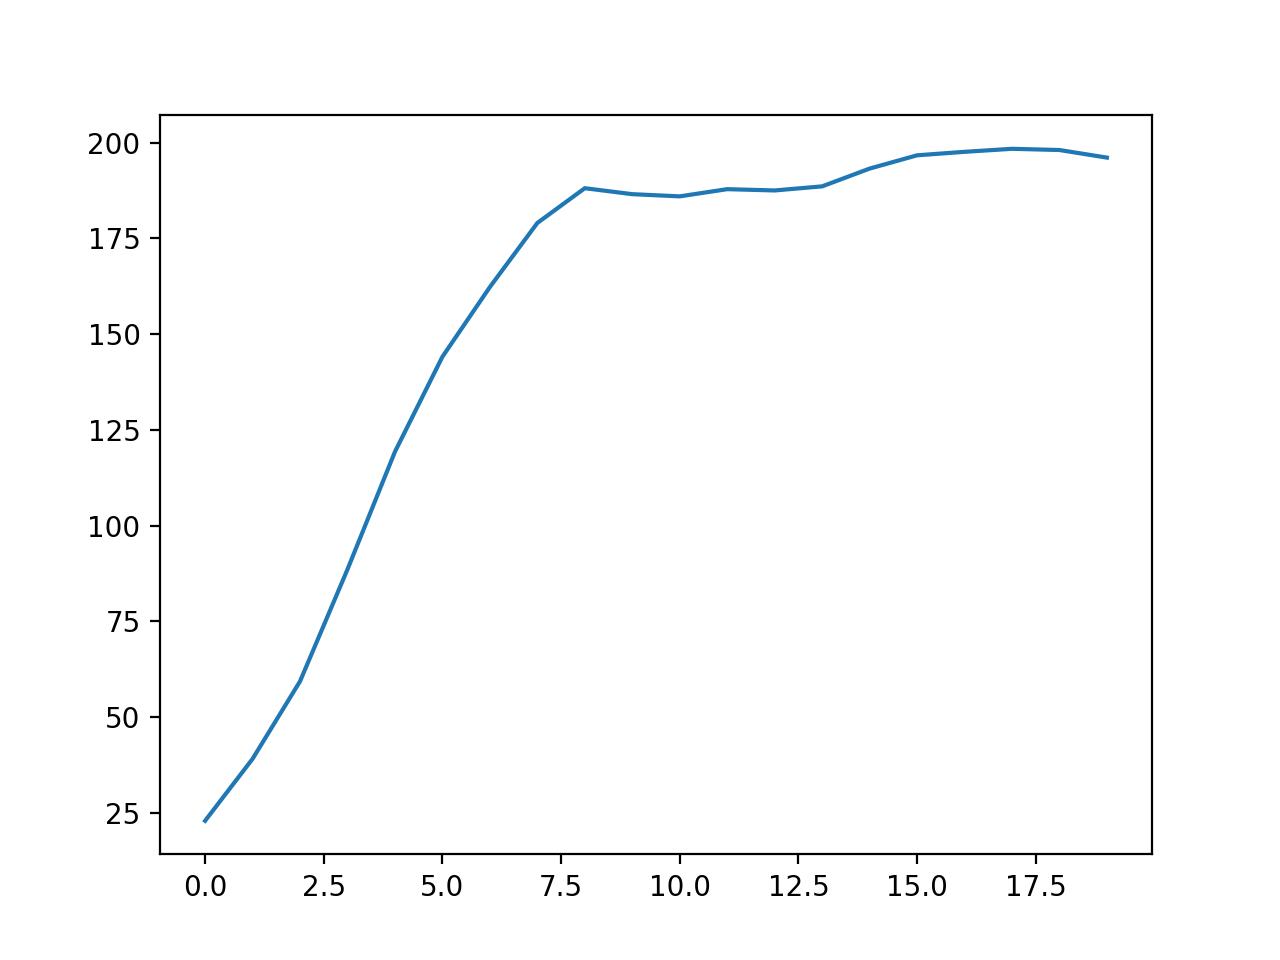

In [44]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [45]:
# ! pip install tensorboard

In [46]:
# ! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


In [52]:
ray.is_initialized()

True

In [53]:
ray.nodes()

[{'NodeID': '41c26152d8eecc51f1a4fec2eec4a79eb681081f',
  'Alive': True,
  'NodeManagerAddress': '10.236.176.76',
  'NodeManagerHostname': 'qian-XPS-8920',
  'NodeManagerPort': 54719,
  'ObjectManagerPort': 46637,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/raylet',
  'Resources': {'node:10.236.176.76': 1.0,
   'object_store_memory': 25.0,
   'CPU': 8.0,
   'memory': 74.0,
   'GPU': 1.0},
  'alive': True}]

In [54]:
ray.cluster_resources()

{'node:10.236.176.76': 1.0,
 'object_store_memory': 25.0,
 'CPU': 8.0,
 'memory': 74.0,
 'GPU': 1.0}

In [55]:
ray.shutdown()

In [56]:
ray.is_initialized()

False